
In this notebook, You will do amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below.  Detailed instrctions are given in the each cell. please read every comment we have written. 
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. 
    If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List if we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>
</pre>

In [29]:
#all imports
import numpy as np
import pandas as pd
import re
import pickle
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [30]:
tf.test.gpu_device_name()

'/device:GPU:0'

<font size=4>Grader function 1 </font>

In [31]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [32]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [33]:
#get only 2 columns - Text, Score
#drop the NAN values
reviews = reviews[['Text', 'Score']]
reviews.dropna(inplace=True)

print(reviews.shape)
reviews.head()

(568454, 2)


,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [34]:
#if score> 3, set score = 1
#if score<=2, set score = 0
#if score == 3, remove the rows.

reviews.drop(reviews[reviews['Score']==3].index, inplace = True)
reviews['Score'] = reviews['Score'].apply(lambda x: 1 if x>3 else 0)
print(reviews.shape)
reviews.head()

(525814, 2)


,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


<font size=4>Grader function 2 </font>

In [35]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [36]:
def get_wordlen(x):
    return len(x.split())

reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [37]:
#remove HTML from the Text column and save in the Text column only

reviews['Text'] = reviews['Text'].apply(lambda x: re.sub(r'\<.*?\>', '', x))

In [38]:
#print head 5
print(reviews.shape)
reviews.head()

(100000, 3)


,Text,Score,len
64117,The tea was of great quality and it tasted lik...,1,30
418112,My cat loves this. The pellets are nice and s...,1,31
357829,Great product. Does not completely get rid of ...,1,41
175872,This gum is my favorite! I would advise every...,1,27
178716,I also found out about this product because of...,1,22


In [39]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews['Text'], reviews['Score'], test_size=0.20, random_state=33)

print('train size', X_train.shape, y_train.shape)
print('test size', X_test.shape, y_test.shape)

train size (80000,) (80000,)
test size (20000,) (20000,)


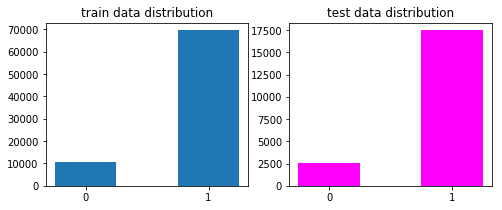

In [40]:
#plot bar graphs of y_train and y_test
from collections import Counter
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
plt.subplot(1, 2, 1)
plt.bar(Counter(y_train).keys(), Counter(y_train).values(), width=0.5,);
plt.title('train data distribution')
plt.xticks([0,1]);

plt.subplot(1, 2, 2)
plt.bar(Counter(y_test).keys(), Counter(y_test).values(), width=0.5, color='magenta');
plt.title('test data distribution')
plt.xticks([0,1]);

In [41]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [42]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


OSError: SavedModel file does not exist at: C:\Users\Nehal\AppData\Local\Temp\tfhub_modules\03d6fb3ce1605ad9e5e9ed5346b2fb9623ef4d3d/{saved_model.pbtxt|saved_model.pb}

In [ ]:
bert_model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(bert_model, 'bert_model.png', show_shapes=True)

In [ ]:
bert_model.output

<pre><font size=6>Part-3: Tokenization</font></pre>

In [ ]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
# import tokenization - We have given tokenization.py file
import tokenization

In [ ]:
# Create tokenizer " Instantiate FullTokenizer", name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation

tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

<font size=4>Grader function 3 </font>

In [ ]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

In [ ]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)

# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

# print(type(X_train))

def tokenize_and_padding(data):
    data_tokens = []
    masks = []
    segments = []
    for sentence in data:
        token = tokenizer.tokenize(sentence)
        if len(token) <= (max_seq_length-2):
            token = ['[CLS]'] + token + ['[SEP]']
            mask = len(token)*[1]
            if len(token) < max_seq_length:
                token = token + (max_seq_length-len(token))*['[PAD]']
                mask = mask + (max_seq_length-len(mask))*[0]
        else:
            token = ['[CLS]'] + token[0:(max_seq_length-2)] + ['[SEP]']
            mask = max_seq_length * [1]
        data_tokens.append(np.array(tokenizer.convert_tokens_to_ids(token)))
        masks.append(mask)
        segments.append(max_seq_length*[0])
        
    return np.array(data_tokens), np.array(masks), np.array(segments)
#         token = []
      
X_train_tokens, X_train_mask, X_train_segment = tokenize_and_padding(X_train.values)
X_test_tokens, X_test_mask, X_test_segment = tokenize_and_padding(X_test.values)

X_train_tokens.shape, X_train_mask.shape, X_train_segment.shape

In [191]:
# print(X_train_tokens[9])

In [192]:
print(X_train_tokens[0], '\n')
print(X_train_mask[0], '\n')
print(X_train_segment[0], '\n')

[  101  2026  5440  2061  2521  1012  7782  2021  5744  2007  2053  8618
  2044  5510  1012  3811 16755  2065  2017  2066  1037  7782  4157  1012
   102     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0] 

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 



#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [186]:
import pickle

In [187]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train), open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test), open('test_data.pkl','wb'))

In [0]:
#you can load from disk
#X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
#X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<font size=4>Grader function 4 </font>

In [188]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
        
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [193]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

True

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [194]:
bert_model.input

[<tf.Tensor 'input_word_ids:0' shape=(None, 55) dtype=int32>,
 <tf.Tensor 'input_mask:0' shape=(None, 55) dtype=int32>,
 <tf.Tensor 'segment_ids:0' shape=(None, 55) dtype=int32>]

In [195]:
bert_model.output

<tf.Tensor 'keras_layer/Identity:0' shape=(None, 768) dtype=float32>

In [196]:
# get the train output, BERT model will give one output so save in X_train_pooled_output
X_train_pooled_output = bert_model.predict([X_train_tokens, X_train_mask, X_train_segment])

In [197]:
# get the test output, BERT model will give one output so save in X_test_pooled_output
X_test_pooled_output = bert_model.predict([X_test_tokens, X_test_mask, X_test_segment])

In [198]:
# save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output), open('final_output.pkl','wb'))

In [202]:
print('train shape:', X_train_pooled_output.shape)
print('test shape:', X_test_pooled_output.shape)

train shape: (80000, 768)
test shape: (20000, 768)


In [3]:
X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

<font size=4>Grader function 6 </font>

In [14]:
# now we have X_train_pooled_output, y_train X_test_pooled_ouput, y_test

# please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(y_test)==len(X_test_pooled_output))
    assert(len(y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

True

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric.</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [15]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Model

In [16]:
##create an NN and 
input_layer = tf.keras.layers.Input(shape=(768,))
dense1 = Dense(512, activation='relu', name='dense1')(input_layer)
drop1 = Dropout(0.5, name='dropout1')(dense1)
dense2 = Dense(64, activation='relu', name='dense2')(drop1)
drop2 = Dropout(0.5, name='dropout2')(dense2)
dense3 = Dense(16, activation='relu', name='dense3')(drop2)
drop3 = Dropout(0.5, name='dropout3')(dense3)
dense4 = Dense(4, activation='relu', name='dense4')(drop3)
output_layer = Dense(units=2, activation='softmax')(dense4)

model = Model(input_layer, output_layer)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 768)]             0         
_________________________________________________________________
dense1 (Dense)               (None, 512)               393728    
_________________________________________________________________
dropout1 (Dropout)           (None, 512)               0         
_________________________________________________________________
dense2 (Dense)               (None, 64)                32832     
_________________________________________________________________
dropout2 (Dropout)           (None, 64)                0         
_________________________________________________________________
dense3 (Dense)               (None, 16)                1040      
_________________________________________________________________
dropout3 (Dropout)           (None, 16)                0     

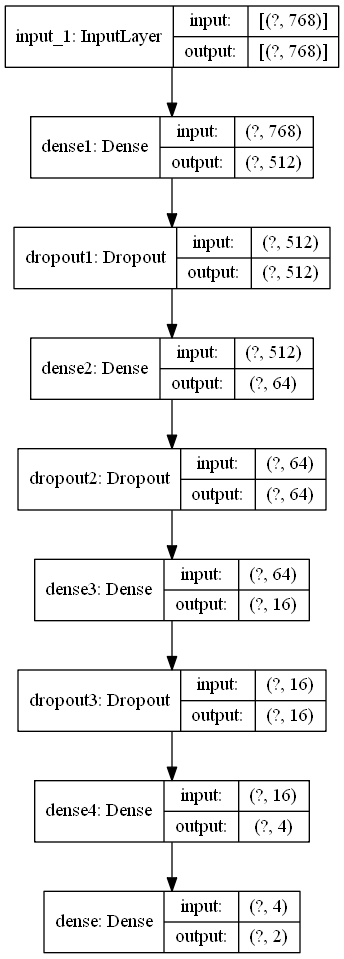

In [17]:
from tensorflow.keras.utils import plot_model

plot_model(model, 'model.png', show_shapes=True)

In [18]:
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=[auc])

In [20]:
tf.keras.backend.clear_session()

In [24]:
log_dir="log\model1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [tensorboard_callback]


model.fit(X_train_pooled_output,
          tf.keras.utils.to_categorical(y_train),
          batch_size=512,
          epochs=25,
          verbose=1,
          validation_split=0.2,
          callbacks=callbacks_list,
     )

Train on 64000 samples, validate on 16000 samples
Epoch 1/25
64000/64000 [==============================] - 6s 88us/sample - loss: 0.2178 - auc: 0.9276 - val_loss: 0.1874 - val_auc: 0.9477
Epoch 2/25
64000/64000 [==============================] - 3s 45us/sample - loss: 0.2142 - auc: 0.9298 - val_loss: 0.1940 - val_auc: 0.9482
Epoch 3/25
64000/64000 [==============================] - 4s 56us/sample - loss: 0.2138 - auc: 0.9307 - val_loss: 0.1876 - val_auc: 0.94880.2167 - au
Epoch 4/25
64000/64000 [==============================] - 3s 47us/sample - loss: 0.2118 - auc: 0.9323 - val_loss: 0.1852 - val_auc: 0.9491
Epoch 5/25
64000/64000 [==============================] - 3s 44us/sample - loss: 0.2111 - auc: 0.9323 - val_loss: 0.1825 - val_auc: 0.9493
Epoch 6/25
64000/64000 [==============================] - 3s 43us/sample - loss: 0.2101 - auc: 0.9328 - val_loss: 0.1826 - val_auc: 0.9497
Epoch 7/25
64000/64000 [==============================] - 3s 43us/sample - loss: 0.2094 - auc: 0.9344 - v

In [25]:
y_pred = model.predict(X_test_pooled_output)

In [26]:
y_test_ohe = tf.keras.utils.to_categorical(y_test)

print('Test AUC score: {} %'.format(float(auc(y_test_ohe, y_pred))*100))

Test AUC score: 95.38417659047067 %


<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 

1. Download data from <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a>
2. Read the csv file
3. Remove all the html tags
4. Now do tokenization [Part 3 as mentioned above]
    * Create tokens,mask array and segment array
5. Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
   * Print the shape of output(X_test.shape).You should get (352,768)
6. Predit the output of X_test with the Neural network model which we trained earlier.
7. Print the occurences of class labels in the predicted output

</pre>

In [41]:
data = pd.read_csv('test.csv')

data['Text'] = data['Text'].apply(lambda x: re.sub(r'\<.*?\>', '', x))

data_tokens, data_mask, data_segment = tokenize_and_padding(data['Text'].values)

data_pooled_output = bert_model.predict([data_tokens, data_mask, data_segment])
print('shape of data_pooled_output:', data_pooled_output.shape)

data_pred = model.predict(data_pooled_output)

data_label = Counter(np.argmax(data_pred, axis=1, out=None))

print("Occurence of Class 0 labels:", data_label[0])
print("Occurence of Class 1 labels:", data_label[1])

shape of data_pooled_output: (352, 768)
Occurence of Class 0 labels: 52
Occurence of Class 1 labels: 300


##### Steps to solve this assignment.

**1** - since Score value of Amazong food review are between 1 to 5, discarding the review with score value of 3 and assigning value 0 to score value of less than 3 and value 1 to grater thant 3.

**2** - After proprocessing(removing markup tags) the text, only taking the text whose length is less than 50 and converting them into 768 feaures using Transfer Learnig of BERT model with 12 hidden layers and 12 attention heads and max_seq_lenght=55.

**3** - A simple sequential neural network model is trained with these 768 features using metric AUC score.